## Lane Lines detection

The main goal of this implementation is the detect the lane boundaries, from images captured from a front-facing camera.
The processing pipeline takes an image, filters it (using a Sobel filter). This highlights the areas with high gradient changes. 

The perspective of the filtered image is changed (bird's eye view) to make easier lane detection. Then a window is applied to create a histogram of detections. The peek is taken as the highest probability for the lane. Based on the peak position, the detector-window position is adjusted to follow the detections (i.e. curve position).

After all the points were detected, a polynomial fit is applied, and a curve is interpolated. What is remaining is to un-warp the image and visualize the points.

The implementation can be tweaked to different scenarios, for outliers RANSAC can be used, or in case of a missing middle line, an equidistant approximated line can be generated.

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob

from utils.detector import Detector
from utils.interpolator import Interpolator
from utils.imagewarp import ImageWarp

%matplotlib inline
#%matplotlib qt5

# src = [[20, 240], [300, 240], [0, 0], [320, 0]]
src = [[70, 240], [450, 240], [0, 0], [500, 0]]
dst = [[135, 270], [150, 270], [0, 0], [320, 0]]
# dst = [[150, 270], [160, 270], [0, 0], [320, 0]]
scan_range={'start':0,'stop':240,'steps':10}
scan_window={'height':8,'max_adjust':8}
offset = 150

DISPLAY_COLS = 1
DISPLAY_ROWS = 2

SAVE_RESULTS = False
ESTIMATE_FROM_1_LANE = False

if ESTIMATE_FROM_1_LANE == False:
    lanes =[
        # {'label':'mid','detections':{'start':{'x':80,'y':230},'stop':{'x':120,'y':230}}}, 
        # {'label':'right','detections':{'start':{'x':395,'y':230},'stop':{'x':430,'y':230}}}
        {'label': 'mid', 'detections': {'start': {'x': 110, 'y': 230}, 'stop': {'x': 145, 'y': 220}}},
        {'label': 'right', 'detections': {'start': {'x': 145, 'y': 230}, 'stop': {'x': 180, 'y': 220}}}
        ]
else:
    lanes =[{'label':'right','detections':{'start':{'x':145,'y':230},'stop':{'x':175,'y':230}}}
           ]

iw_obj = ImageWarp(img_w=500,offset=offset,src=src,dst=dst)
det_obj = Detector(scan_range=scan_range,scan_window=scan_window)
ip_obj = Interpolator(max_poly_degree=2)

<Figure size 640x480 with 0 Axes>

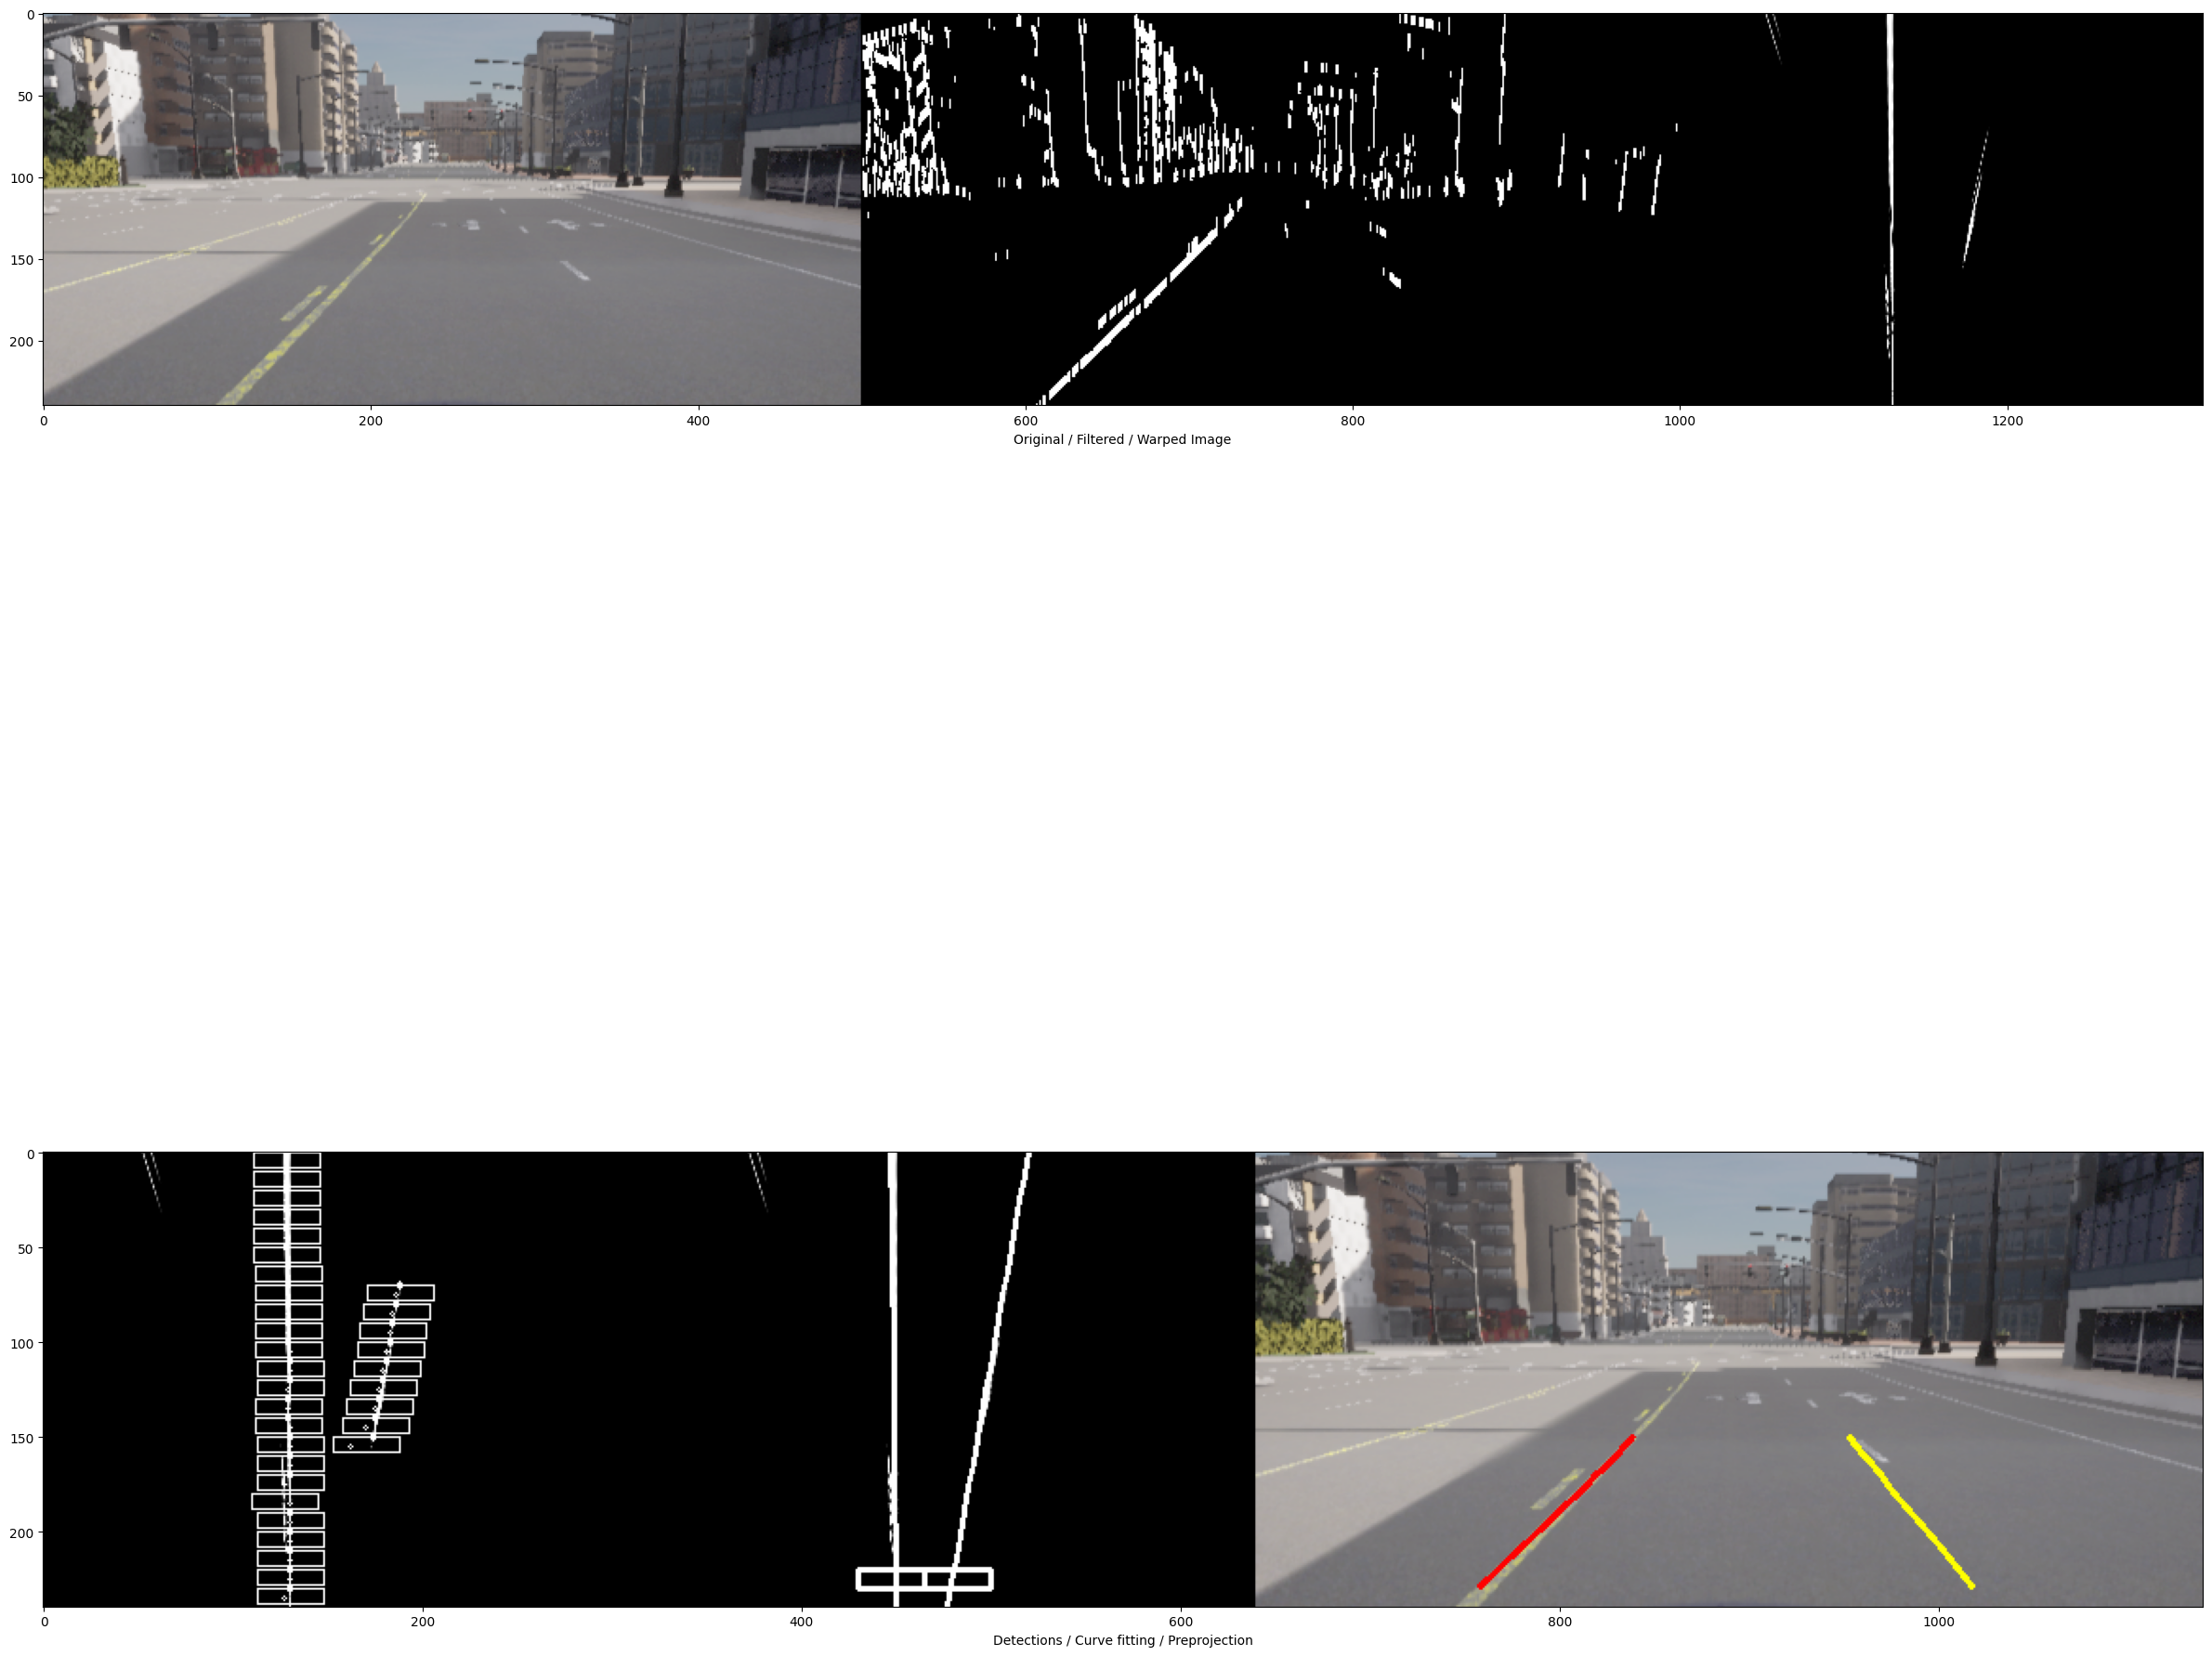

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob

# Percorso dell'immagine
imgpath = './cropped_img.png'
test_img_list = glob.glob(imgpath)

# Carica l'immagine
img = cv2.imread(test_img_list[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

oimg = img.copy()

# Filtra e trasforma l'immagine
f_img = det_obj.img_filter(img)
f_w_img = iw_obj.img_warp(f_img, offset=True)
color = [1, 1, 1]

img_detected_points = f_w_img.copy()
img_line_fitted = f_w_img.copy()

for i, lane in enumerate(lanes):
    detected_points = det_obj.get_lane_detections(f_w_img, start=lane['detections']['start'], stop=lane['detections']['stop'], label=lane['label'], use_RANSAC=True, debug=True)
    img_detected_points = det_obj.draw_detections(img_detected_points, detected_points[lane['label']])
    
    interpolated_points = ip_obj.interpolate([detected_points], key=lane['label'], equ_selector=False, debug=False)
    
    pts = np.array([interpolated_points[lane['label']]])
    cv2.polylines(img_line_fitted, [np.int32(pts)], False, [255], 2)
    
    unwarped_pts = np.int32(iw_obj.pts_unwarp(pts))
    unwarped_pts_offset = np.add(unwarped_pts, [0, offset])
    
    color[i] = 255
    cv2.polylines(img, [unwarped_pts_offset], False, color, 2)
    
    if ESTIMATE_FROM_1_LANE == True:
        ed_pts = np.float32(ip_obj.echidistant_lane(pts, return_end_point=True, distnce=40))
        cv2.polylines(img_line_fitted, [np.int32(ed_pts)], False, [255], 2)

        ed_unwarped_pts = np.int32(iw_obj.pts_unwarp(ed_pts))
        ed_unwarped_pts_offset = np.add(ed_unwarped_pts, [0, offset])

        cv2.polylines(img, [ed_unwarped_pts_offset], False, color, 2)


    # Disegna l'area di valutazione delle corsie
    start_x = lane['detections']['start']['x']
    start_y = lane['detections']['start']['y']
    stop_x = lane['detections']['stop']['x']
    stop_y = lane['detections']['stop']['y']
    cv2.rectangle(img_line_fitted, (start_x, start_y), (stop_x, stop_y), (255, 255, 255), 2)

# Concatenare le immagini
concat_img = cv2.hconcat([oimg, cv2.cvtColor(f_img, cv2.COLOR_GRAY2RGB), cv2.cvtColor(f_w_img[:, :320], cv2.COLOR_GRAY2RGB)])
concat_img1 = cv2.hconcat([cv2.cvtColor(img_detected_points[:, :320], cv2.COLOR_GRAY2RGB), cv2.cvtColor(img_line_fitted[:, :320], cv2.COLOR_GRAY2RGB), img])

if SAVE_RESULTS == True:
    cv2.imwrite('./concat_img.jpg', cv2.cvtColor(concat_img, cv2.COLOR_BGR2RGB))
    cv2.imwrite('./concat_img1.jpg', cv2.cvtColor(concat_img1, cv2.COLOR_BGR2RGB))

fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=DISPLAY_COLS, nrows=DISPLAY_ROWS, figure=fig)
fig = plt.figure(figsize=(30, 30))

subplot = fig.add_subplot(spec[0, 0])
subplot.set_xlabel('Original / Filtered / Warped Image')
subplot.imshow(concat_img)

subplot = fig.add_subplot(spec[1, 0])
subplot.set_xlabel('Detections / Curve fitting / Preprojection')
subplot.imshow(concat_img1)

Wall time: 0 ns


<Figure size 640x480 with 0 Axes>

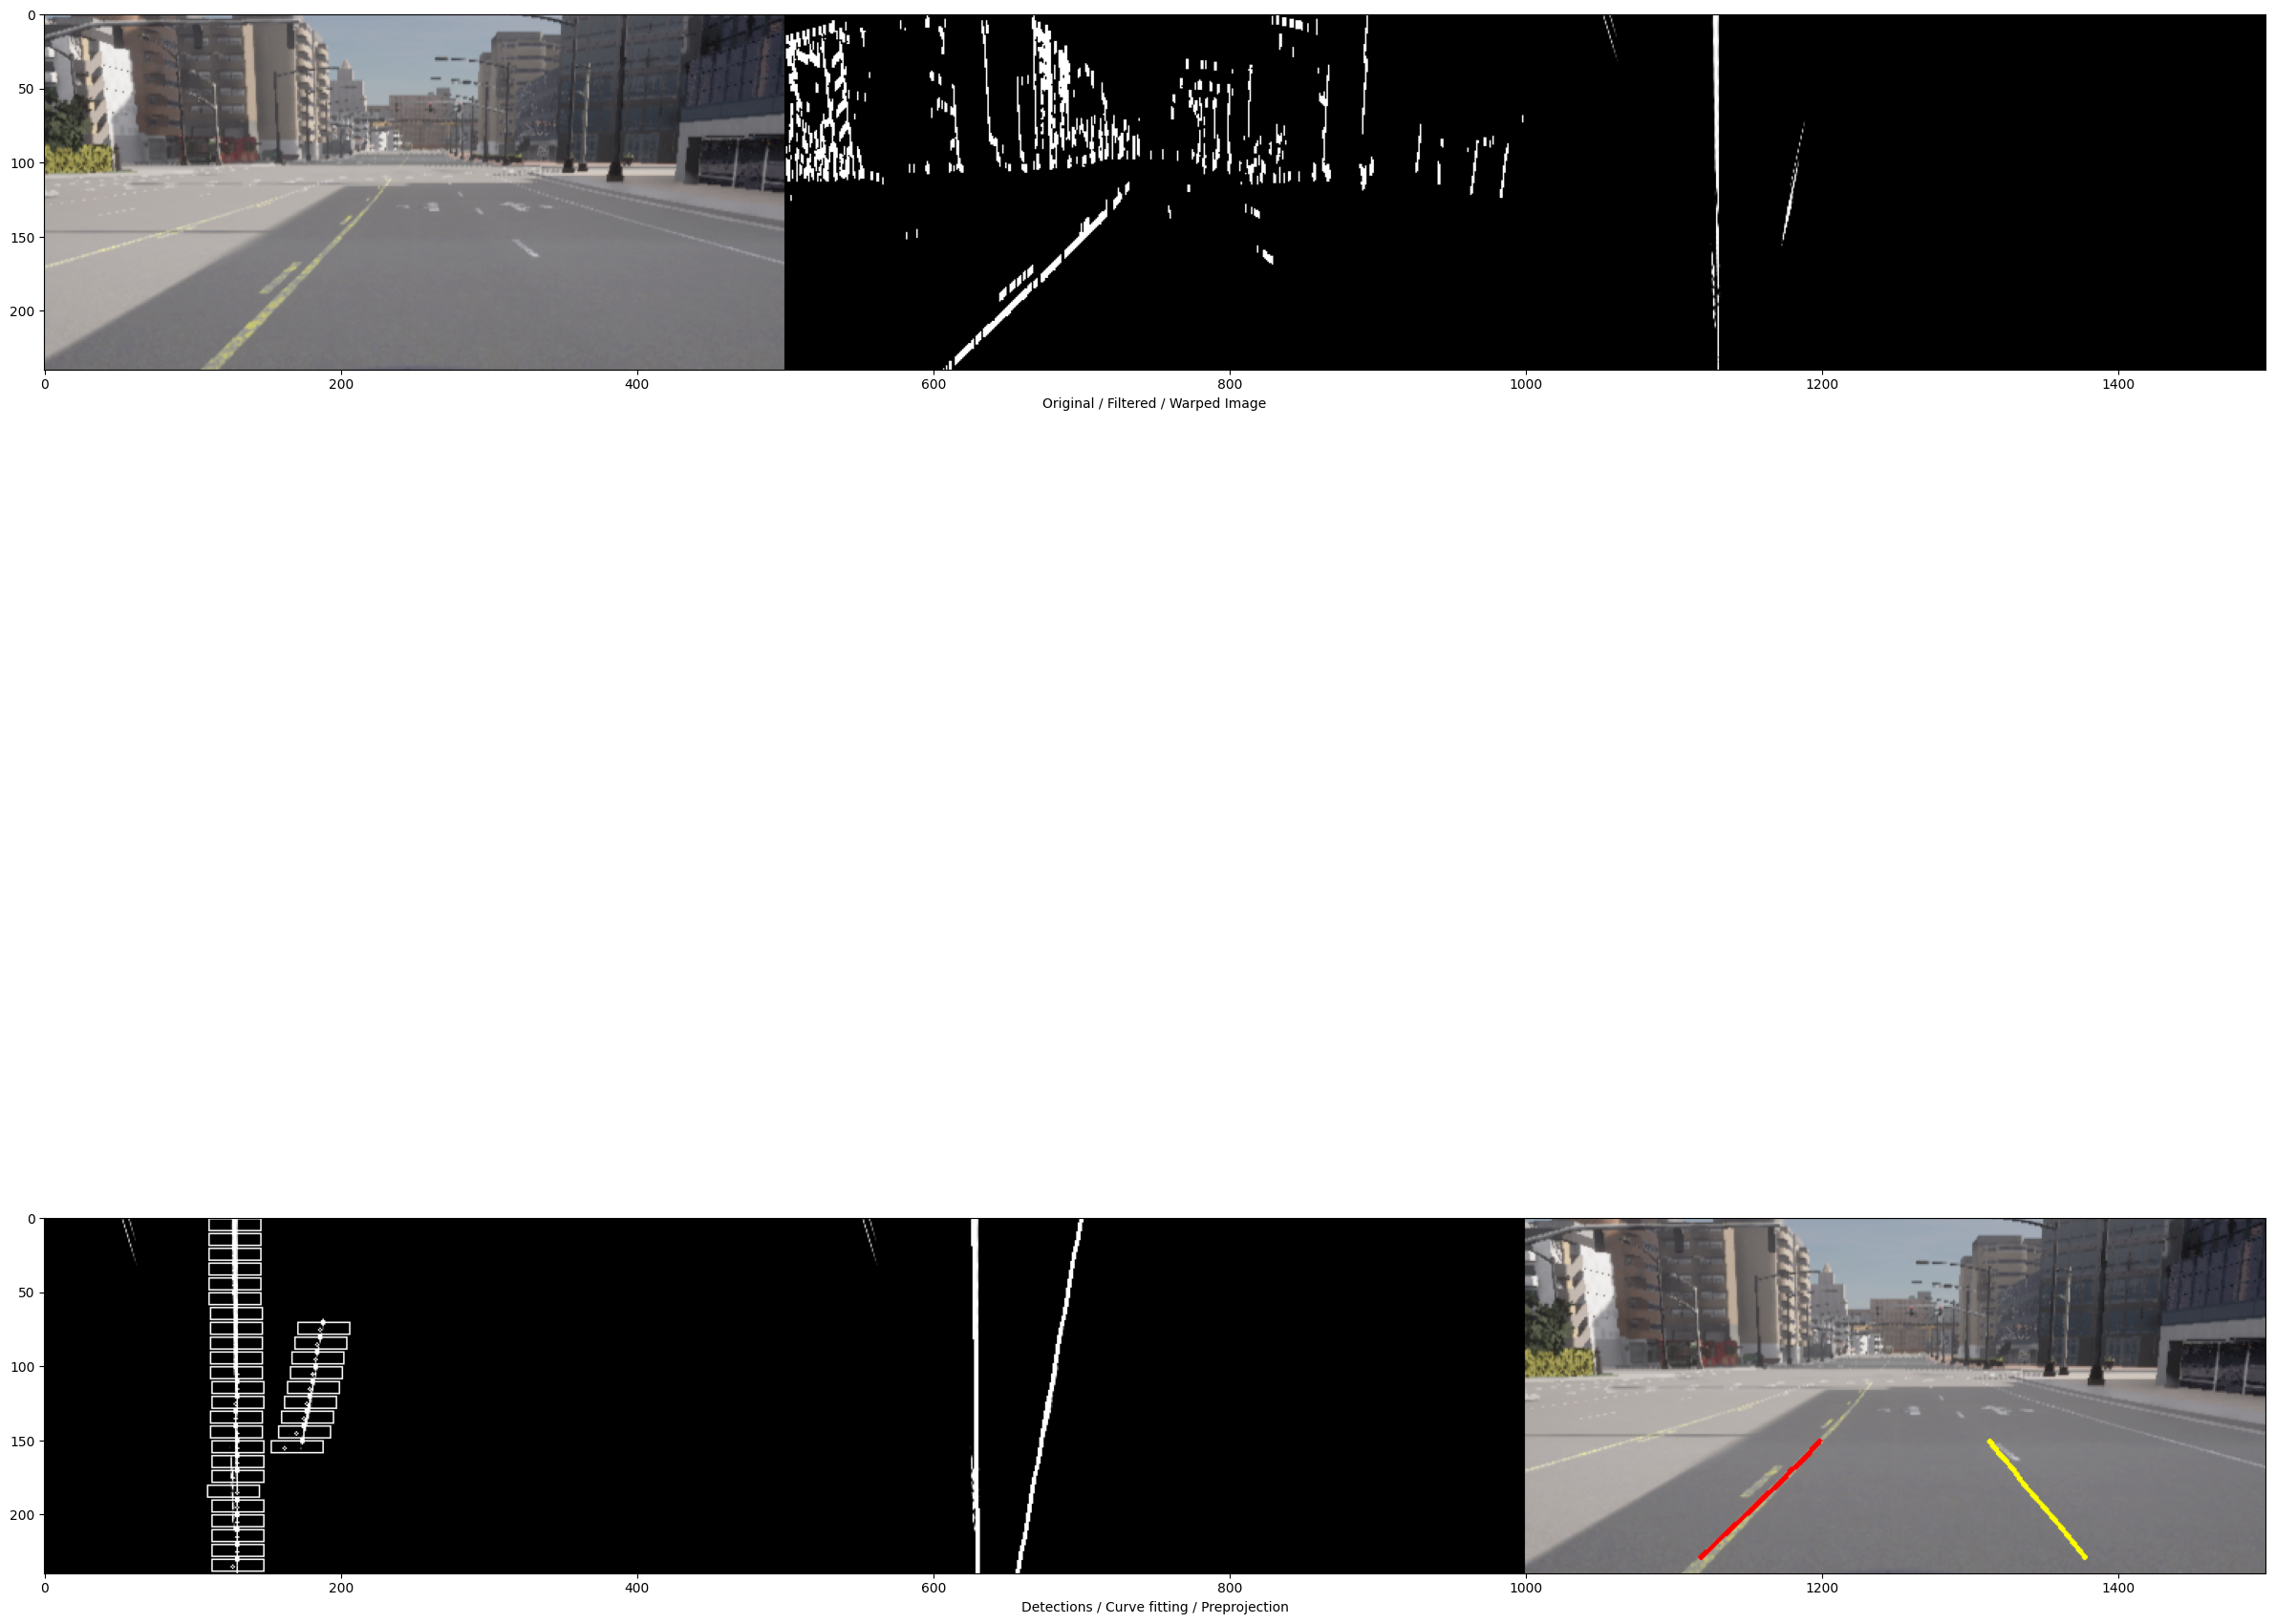

In [8]:
%time

imgpath = './cropped_img.png'
test_img_list = glob.glob(imgpath)

img = cv2.imread(test_img_list[0])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

oimg = img.copy()

f_img = det_obj.img_filter(img)
f_w_img = iw_obj.img_warp(f_img,offset=True)
color = [1,1,1]

img_detected_points = f_w_img.copy()
img_line_fitted = f_w_img.copy()

for i,lane in enumerate(lanes):
    detected_points = det_obj.get_lane_detections(f_w_img,start=lane['detections']['start'],stop=lane['detections']['stop'],label=lane['label'],use_RANSAC=True, debug=True)
    img_detected_points = det_obj.draw_detections(img_detected_points,detected_points[lane['label']])
    
    interpolated_points = ip_obj.interpolate([detected_points],key=lane['label'],equ_selector=False,debug=False)
    
    pts = np.array([interpolated_points[lane['label']]])
    cv2.polylines(img_line_fitted, [np.int32(pts)], False, [255], 2)
    
    unwarped_pts = np.int32(iw_obj.pts_unwarp(pts))
    unwarped_pts_offset = np.add(unwarped_pts,[0,offset])
    
    color[i]=255
    cv2.polylines(img, [unwarped_pts_offset], False, color, 2)
    
    if ESTIMATE_FROM_1_LANE == True:
        ed_pts = np.float32(ip_obj.echidistant_lane(pts,return_end_point=True, distnce=40))
        cv2.polylines(img_line_fitted, [np.int32(ed_pts)], False, [255], 2)

        ed_unwarped_pts = np.int32(iw_obj.pts_unwarp(ed_pts))
        ed_unwarped_pts_offset = np.add(ed_unwarped_pts,[0,offset])

        cv2.polylines(img, [ed_unwarped_pts_offset], False, color, 2)


concat_img = cv2.hconcat([oimg,cv2.cvtColor(f_img,cv2.COLOR_GRAY2RGB),cv2.cvtColor(f_w_img,cv2.COLOR_GRAY2RGB)])
concat_img1 = cv2.hconcat([cv2.cvtColor(img_detected_points,cv2.COLOR_GRAY2RGB),cv2.cvtColor(img_line_fitted,cv2.COLOR_GRAY2RGB),img])

if SAVE_RESULTS == True:
    cv2.imwrite('./concat_img.jpg',cv2.cvtColor(concat_img, cv2.COLOR_BGR2RGB))
    cv2.imwrite('./concat_img1.jpg',cv2.cvtColor(concat_img1, cv2.COLOR_BGR2RGB))

fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=DISPLAY_COLS, nrows=DISPLAY_ROWS, figure=fig)
fig = plt.figure(figsize=(30, 30))

subplot = fig.add_subplot(spec[0,0])
subplot.set_xlabel('Original / Filtered / Warped Image')
subplot.imshow(concat_img)

subplot = fig.add_subplot(spec[1,0])
subplot.set_xlabel('Detections / Curve fitting / Preprojection')
subplot.imshow(concat_img1)


Image shape: (240, 500, 3)


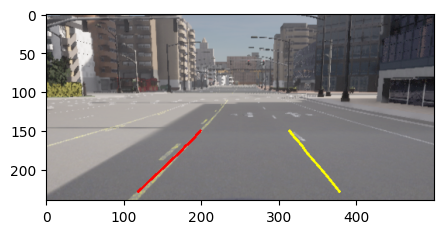

In [9]:
print('Image shape:',img.shape)
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()